In [ ]:
# Imports and Style

In [3]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Make plots look nice
plt.style.use('seaborn-v0_8-whitegrid')


In [ ]:
# Load and Clean the Data

In [13]:
# Load your dataset
df = pd.read_csv("benchmark_set_with_sequences.tsv", sep="\t")

# Drop rows where the Sequence is missing (NaN)
df = df.dropna(subset=['Sequence'])

# Keep only positive examples (proteins with confirmed signal peptides)
df = df[df['Class'] == 'Positive']

# Rename columns for simplicity
df = df.rename(columns={'Sequence': 'sequence', 'SPEnd': 'SPEnd'})

# Show dataset info
print("✅ Data loaded successfully")
print("Number of positive sequences:", len(df))
df.head()


✅ Data loaded successfully
Number of positive sequences: 211


,EntryID,OrganismName,Kingdom,SequenceLength,SPStart,SPEnd,Class,sequence
1,Q10ST8,Oryza sativa subsp. japonica,Viridiplantae,96,1.0,27.0,Positive,MMRKLAVLVLAVAMVAACGGGVVGVAGAGCNAGQLTVCTGAIAGGA...
5,P07529,Naganishia albida,Fungi,332,1.0,21.0,Positive,MLSSTTLLAILSALALTSVQAAPADKNSLDYLANKAGKRYLGTAVQ...
8,Q9ES58,Rattus norvegicus,Metazoa,327,1.0,23.0,Positive,MLCFWRTSHVAVLLIWGVFAAESSCPDKNQTMQNNSSTMTEVNTTV...
10,Q6XE38,Homo sapiens,Metazoa,83,1.0,21.0,Positive,MRLSVCLLMVSLALCCYQAHALVCPAVASEITVFLFLSDAAVNLQV...
14,Q96BY9,Homo sapiens,Metazoa,339,1.0,30.0,Positive,MAAACGPGAAGYCLLLGLHLFLLTAGPALGWNDPDRMLLRDVKALT...


In [ ]:
#Extract Windows (-13 to +2)

In [15]:
window_size = 16  # total window length
left = 13         # number of residues before cleavage
right = 2         # residues after cleavage

windows = []

for seq, cleave in zip(df['sequence'], df['SPEnd']):
    seq = str(seq).strip()
    cleave = int(cleave)
    if cleave > left and cleave + right < len(seq):
        window = seq[cleave - left : cleave + right + 1]
        windows.append(window)

windows = np.array(windows)
print(f"Extracted {len(windows)} windows of length {len(windows[0])}")


Extracted 211 windows of length 16


In [ ]:
# Count Amino Acid Frequencies per Position

In [17]:
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
pos_counts = {pos: Counter() for pos in range(window_size)}

for window in windows:
    for pos, aa in enumerate(window):
        if aa in amino_acids:
            pos_counts[pos][aa] += 1

# Convert to DataFrame
freq_df = pd.DataFrame(pos_counts).fillna(0).astype(int)
freq_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
V,25,23,27,26,16,13,9,34,11,13,45,10,1,7,10,21
A,25,22,19,17,42,34,26,26,31,20,65,23,111,30,9,10
M,8,0,3,1,6,3,6,8,3,5,2,5,2,4,2,3
L,77,99,93,94,77,70,78,54,13,31,9,27,4,23,9,24
F,16,16,12,13,10,11,18,9,5,11,1,6,1,6,7,8


In [ ]:
# Normalize (Add Pseudocounts and Convert to Probabilities)

In [19]:
freq_df = freq_df + 1  # add pseudocount
prob_df = freq_df / freq_df.sum(axis=0)
prob_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
V,0.113043,0.103896,0.121739,0.116883,0.073593,0.060870,0.043290,0.152174,0.052174,0.060606,0.200000,0.047826,0.008696,0.034632,0.047619,0.095238
A,0.113043,0.099567,0.086957,0.077922,0.186147,0.152174,0.116883,0.117391,0.139130,0.090909,0.286957,0.104348,0.486957,0.134199,0.043290,0.047619
M,0.039130,0.004329,0.017391,0.008658,0.030303,0.017391,0.030303,0.039130,0.017391,0.025974,0.013043,0.026087,0.013043,0.021645,0.012987,0.017316
L,0.339130,0.432900,0.408696,0.411255,0.337662,0.308696,0.341991,0.239130,0.060870,0.138528,0.043478,0.121739,0.021739,0.103896,0.043290,0.108225
F,0.073913,0.073593,0.056522,0.060606,0.047619,0.052174,0.082251,0.043478,0.026087,0.051948,0.008696,0.030435,0.008696,0.030303,0.034632,0.038961


In [ ]:
# Compute Log-Odds vs Background Frequencies

In [21]:
# Background amino acid frequencies (SwissProt-like)
background = {
    'A': 0.08, 'S': 0.07, 'D': 0.05, 'E': 0.06, 'F': 0.04, 'G': 0.07,
    'H': 0.02, 'I': 0.06, 'K': 0.06, 'L': 0.09, 'M': 0.02, 'N': 0.04,
    'P': 0.05, 'Q': 0.04, 'R': 0.05, 'T': 0.06, 'V': 0.07, 'W': 0.01,
    'Y': 0.03, 'C': 0.02
}

log_odds = prob_df.copy()

for aa in prob_df.index:
    for pos in prob_df.columns:
        log_odds.loc[aa, pos] = math.log2(prob_df.loc[aa, pos] / background[aa])

log_odds.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
V,0.691451,0.569715,0.798366,0.739640,0.072215,-0.201634,-0.693320,1.120294,-0.424026,-0.207893,1.514573,-0.549557,-3.008989,-1.015248,-0.555816,0.444184
A,0.498806,0.315669,0.120294,-0.037968,1.218372,0.927649,0.546995,0.553254,0.798366,0.184425,1.842760,0.383329,2.605721,0.746303,-0.885965,-0.748461
M,0.968291,-2.207893,-0.201634,-1.207893,0.599462,-0.201634,0.599462,0.968291,-0.201634,0.377070,-0.616671,0.383329,-0.616671,0.114035,-0.622930,-0.207893
L,1.913843,2.266038,2.183030,2.192038,1.907584,1.778188,1.925963,1.409801,-0.564204,0.622182,-1.049631,0.435796,-2.049631,0.207145,-1.055890,0.266038
F,0.885829,0.879570,0.498806,0.599462,0.251539,0.383329,1.040035,0.120294,-0.616671,0.377070,-2.201634,-0.394279,-2.201634,-0.400538,-0.207893,-0.037968


In [ ]:
# Save the PSWM Matrix

In [23]:
log_odds.to_csv("PSWM_matrix.csv")
print("✅ PSWM matrix saved as 'PSWM_matrix.csv'")


✅ PSWM matrix saved as 'PSWM_matrix.csv'


In [ ]:
# Visualize the PSWM (Heatmap)

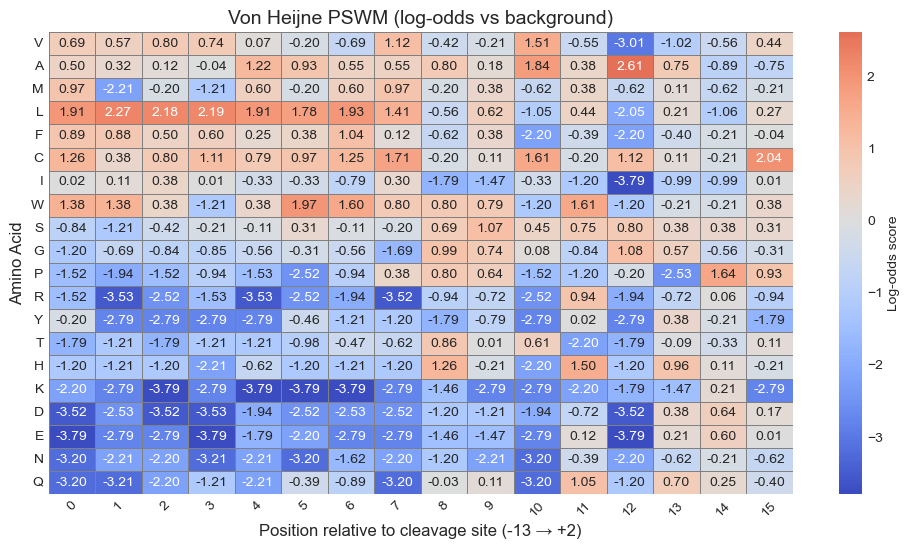

In [27]:
plt.figure(figsize=(12, 6))

# Draw heatmap
sns.heatmap(
    log_odds.astype(float),
    cmap='coolwarm',      # color scheme
    center=0,             # zero-centered
    annot=True,           # show numbers on each cell
    fmt=".2f",            # format numbers with 2 decimals
    linewidths=0.5,       # lines between cells
    linecolor='gray',     # line color
    cbar_kws={'label': 'Log-odds score'}  # colorbar label
)

plt.title("Von Heijne PSWM (log-odds vs background)", fontsize=14)
plt.xlabel("Position relative to cleavage site (-13 → +2)", fontsize=12)
plt.ylabel("Amino Acid", fontsize=12)
plt.xticks(rotation=45)  # rotate x-axis labels for readability
plt.yticks(rotation=0)   # keep amino acid labels horizontal

plt.show()


In [29]:
log_odds.round(2)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
V,0.69,0.57,0.80,0.74,0.07,-0.20,-0.69,1.12,-0.42,-0.21,1.51,-0.55,-3.01,-1.02,-0.56,0.44
A,0.50,0.32,0.12,-0.04,1.22,0.93,0.55,0.55,0.80,0.18,1.84,0.38,2.61,0.75,-0.89,-0.75
M,0.97,-2.21,-0.20,-1.21,0.60,-0.20,0.60,0.97,-0.20,0.38,-0.62,0.38,-0.62,0.11,-0.62,-0.21
L,1.91,2.27,2.18,2.19,1.91,1.78,1.93,1.41,-0.56,0.62,-1.05,0.44,-2.05,0.21,-1.06,0.27
F,0.89,0.88,0.50,0.60,0.25,0.38,1.04,0.12,-0.62,0.38,-2.20,-0.39,-2.20,-0.40,-0.21,-0.04
C,1.26,0.38,0.80,1.11,0.79,0.97,1.25,1.71,-0.20,0.11,1.61,-0.20,1.12,0.11,-0.21,2.04
I,0.02,0.11,0.38,0.01,-0.33,-0.33,-0.79,0.30,-1.79,-1.47,-0.33,-1.20,-3.79,-0.99,-0.99,0.01
W,1.38,1.38,0.38,-1.21,0.38,1.97,1.60,0.80,0.80,0.79,-1.20,1.61,-1.20,-0.21,-0.21,0.38
S,-0.84,-1.21,-0.42,-0.21,-0.11,0.31,-0.11,-0.20,0.69,1.07,0.45,0.75,0.80,0.38,0.38,0.31
G,-1.20,-0.69,-0.84,-0.85,-0.56,-0.31,-0.56,-1.69,0.99,0.74,0.08,-0.84,1.08,0.57,-0.56,-0.31
